# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [4]:
# import bespoke modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2, invert_scaling,inverted_conclusion
from walkforward_validation import walk_forward_val, series_to_supervised
from spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf, automatic_wavelet_denoising, automatic_wavelet_denoising_wf

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tabulate import tabulate

# 1. Fourier methods

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


ValueError: x and y must have same first dimension, but have shapes (1999,) and (2000,)

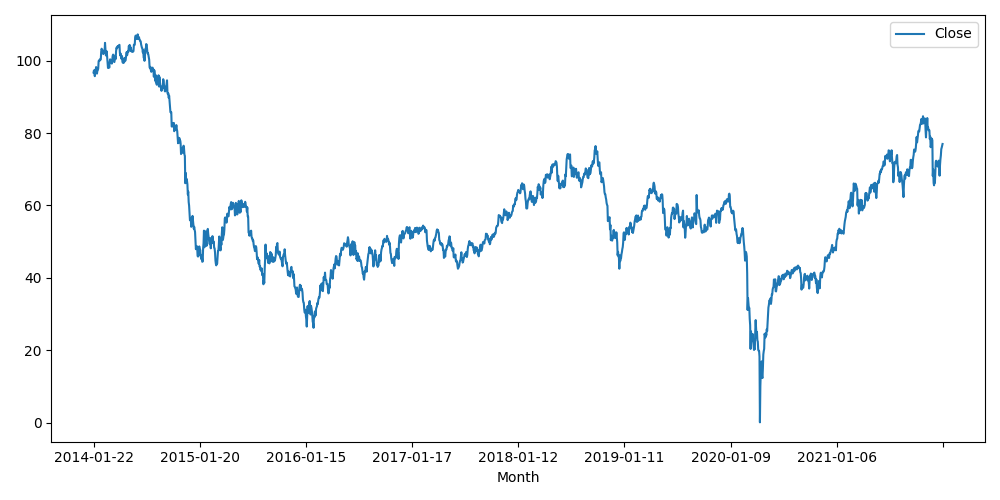

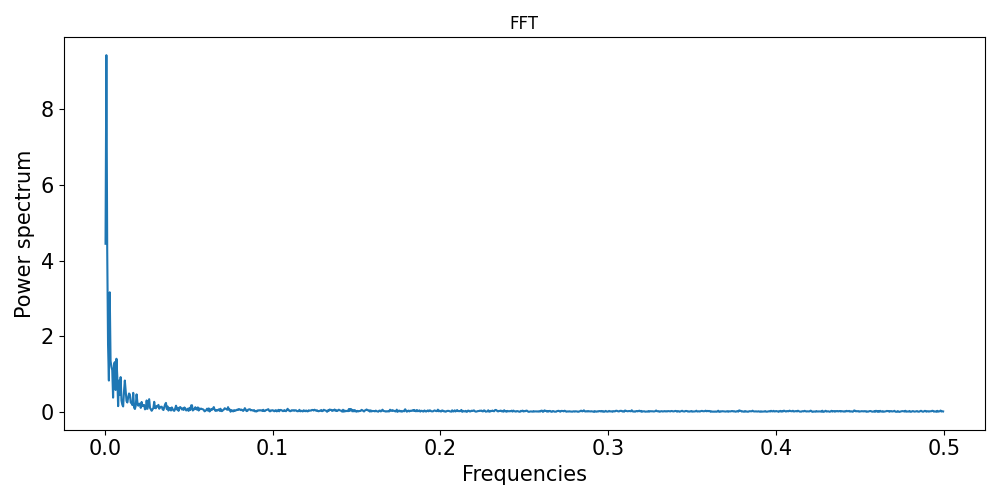

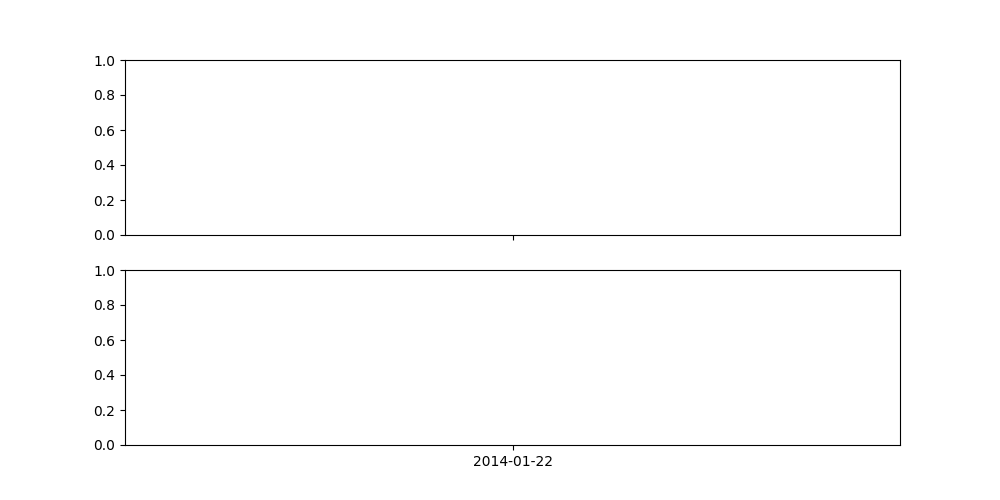

In [7]:
financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'fourier_wrong'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:]) # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! wrong
    denoised_signal = automatic_fourier_denoising(signal,df, split=1,verbose=False)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,model,
                                                                                    original_series = walk_forward_input,
                                                                                    time_series_dates=df['Date'].iloc[-2000:],
                                                                                    lag_window_length=window_length,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_fourier_denoising_wf,
                                                                                    only_training=False,
                                                                                    verbose=False,
                                                                                    threshold_override=False,
                                                                                    threshold=0.05
                                                                                    )
        # wrangle results

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_predictions)

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
        model_pred_results[model_name] = inverted_predictions.flatten()

        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
        ax[0].set_ylabel('Close')

        ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()
        ax[1].set_ylim([0,1])

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')


# 2. Wavelet methods

In [ ]:
# for wavelet in ['db20','coif8']:

financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = f'wavelet_wrong'
column_to_predict = 'Close' #'#Passengers' 
wavelet = 'sym8'

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:]) # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    denoised_signal = automatic_wavelet_denoising(signal,df, split,
                                                    verbose=True,
                                                    wavelet=wavelet,
                                                    threshold_override=False, 
                                                    threshold=0.4)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,model,
                                                                                    original_series = walk_forward_input,
                                                                                    time_series_dates = df['Date'].iloc[-2000:],
                                                                                    lag_window_length=window_length,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_wavelet_denoising_wf,
                                                                                    only_training=False,
                                                                                    verbose=False,
                                                                                    wavelet=wavelet,
                                                                                    threshold_override=False)
        # wrangle results

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_predictions)

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
        model_pred_results[model_name] = inverted_predictions.flatten()

        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
        ax[0].set_ylabel('Close')

        ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()
        ax[1].set_ylim([0,1])

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')

# 3. Moving averages

In [ ]:
# moving average function for feature engineering during walk forward validation
def moving_average_wf(signal,moving_average):
    # numpy array to pandas series
    series = pd.Series(signal)

    # smoothen
    series_smooth = series.rolling(moving_average,min_periods=1).mean().to_numpy()

    return series_smooth
    

In [ ]:
import copy

financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'moving_average_wrong'
column_to_predict = 'Close' #'#Passengers' 


for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # smoothen data
    moving_average = 10
    signal = copy.deepcopy(df[f'{column_to_predict}'][-2000:]) # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    denoised_signal = signal.rolling(moving_average,min_periods=1).mean().to_numpy()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
    ax.plot(df['Date'][:-split], denoised_signal,label=f"MA_{moving_average}") 
    max = df.iloc[:-split,:].shape[0]
    relevant_dates = df['Date'][:-split]
    ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
    plt.legend()
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    # scaler = MinMaxScaler()
    # scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    # scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    # scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # for wrong test input data
    scaler = MinMaxScaler()
    scaled_input_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,
                                                                            model=model,
                                                                            original_series = walk_forward_input,
                                                                            time_series_dates = df[f'Date'].iloc[-2000:],
                                                                            lag_window_length= 10,
                                                                            train_len=225,
                                                                            test_len=25,
                                                                            train_frequency=10,
                                                                            transformer=moving_average_wf,
                                                                            only_training=False,
                                                                            moving_average=moving_average,
                                                                            )
        # wrangle results

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_predictions)

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
        model_pred_results[model_name] = inverted_predictions.flatten()

        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
        ax[0].set_ylabel('Close')

        ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()
        ax[1].set_ylim([0,1])

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')


# 4. Exponentially weighted moving average

In [ ]:
# moving average function for feature engineering during walk forward validation
def ewma_wf(signal,alpha):
    # numpy array to pandas series
    series = pd.Series(signal)

    # smoothen
    series_smooth = series.ewm(alpha=alpha).mean().to_numpy()

    return series_smooth
    

In [ ]:

ma_map = {'ewma_075':0.75} # 'ewma_025':0.25,'ewma_05':0.5,

for ma_name in ma_map.keys():

    financial_asset = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
    feat_engineering = 'ewma_wrong_075'#ma_name#'ewma_05'
    column_to_predict = 'Close' #'#Passengers' 

    for financial_asset in financial_assets:
        ###################################################################################################
        # import some data
        ###################################################################################################

        df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
        df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
        # df['Date'] = df['Month']
        df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
        plt.tight_layout()
        display(df)

        # some forecasting parameters
        window_length = 10
        split = 500 # 44 for AirPlane

        ###################################################################################################
        # feature engineering
        ###################################################################################################

        # smoothen data
        alpha = ma_map[ma_name] # smoothing parameter
        signal = df[f'{column_to_predict}'][-2000:] # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! wrng
        denoised_signal = signal.ewm(alpha=alpha).mean().to_numpy()

        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
        ax.plot(df['Date'][:-split], denoised_signal,label=f"EWMA_{alpha}")
        max = df.iloc[:-split,:].shape[0]
        relevant_dates = df['Date'][:-split]
        ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
        plt.legend()
        plt.tight_layout()
        display(df)

        ###################################################################################################
        # single out of sample validation results
        ###################################################################################################

        # input data
        # scaler = MinMaxScaler()
        # scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
        # scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
        # scaled_input_data = np.append(scaled_training_data,scaled_test_data)

        # for wrong test input data
        scaler = MinMaxScaler()
        scaled_input_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()


        # initialize class object
        blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
        blah.sliding_window_1(verbose=0) # time series to supervised ML problem
        blah.train_test_split(split=split) # testing and training dataset split
        blah.test_train_plot(ylabel='Close price')    # visualize training split

        # perform some prediction tasks
        blah.linear_regression()
        blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
        blah.neural_net_mlp(model_tunning=True,
                            activation= 'relu', 
                            hidden_layer_sizes= (100, 100, 100), 
                            learning_rate= 'invscaling', 
                            learning_rate_init= 0.001,
                            solver='adam')
        blah.lstm(model_tunning=True,n_batch=64)
        blah.naive_model()

        # tabulate results nicely
        blah.collect_results()

        # visualize results
        blah.vis_results_time_series(ylabel='Close price',second_plot='error')

        # view final results
        blah.conclusion()

        ###################################################################################################
        # invert feature engineering (if possible)
        ###################################################################################################

        # invert scaling
        inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
        inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
        inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
        inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

        # collect inverted results

        df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
        df_inverted_results['Date'] = df['Date']
        df_inverted_results['Value'] = df[f'{column_to_predict}']
        df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
        df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
        df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
        df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

        # plot invert results
        ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
        ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
        ax.set_xlabel(xlabel='Date',fontsize=15)
        ax.tick_params(rotation=30, labelsize=12)    
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

        # store results
        inverted_conclusion(dates=df['Date'].iloc[-split:],
                            original_values=df[f'{column_to_predict}'].iloc[-split:], 
                            linear_preds=inverted_predictions_linear, 
                            svm_pred=inverted_predictions_svm, 
                            nn_preds=inverted_predictions_nn, 
                            lstm_preds=inverted_predictions_lstm,
                            financial_asset=financial_asset,
                            feat_engineer=feat_engineering)

        ###################################################################################################
        # walk forward validation results
        ###################################################################################################
        mapping = {'LinearReg':blah.linear_regression_model,
                    'svr':blah.svr_model,
                    'MLP':blah.mlp_model,
                    'LSTM':blah.lstm_model
                    }

        # store evaulation results for different models
        model_results = []
        inverted_results = []
        model_pred_results = {'Original Values':None,
                    'LinearReg':None,
                    'svr':None,
                    'MLP':None,
                    'LSTM':None,
                    }

        # unfeature engineered data for walkforward
        walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

        # apply walkforward for all models
        for model_name in mapping.keys():

            # retrieve model
            model = mapping[model_name]

            # apply walk forward and save results
            train_len = 225 # 48 for Airplane
            test_len = 25   # 12 for Airplane
            df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,
                                                                                model=model,
                                                                                original_series = walk_forward_input,
                                                                                time_series_dates = df[f'Date'].iloc[-2000:],
                                                                                lag_window_length= 10,
                                                                                train_len=225,
                                                                                test_len=25,
                                                                                train_frequency=10,
                                                                                transformer=ewma_wf,
                                                                                only_training=False,
                                                                                alpha = alpha,
                                                                                )
            # wrangle results

            # tables 
            model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

            # invert results for different models

            # invert scaling
            inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

            invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
            invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
            invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
            df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                            original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                            predictions=inverted_predictions)

            inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


            # save prediction so we can view inverted walk forward results too
            model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
            model_pred_results[model_name] = inverted_predictions.flatten()

            # plots
            df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
            
            fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
            ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
            ax[0].set_ylabel('Close')

            ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
            ax[1].set_title('Walk forward error through time')
            ax[1].set_xlabel('Dates')
            ax[1].legend()
            ax[1].set_ylim([0,1])

            max = df_walk_forward.shape[0]
            ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
            ax[1].tick_params(rotation=30)
            ax[1].set_ylabel('Error')
            ax[1].set_xlabel('Date')
            plt.tight_layout()
            plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
            plt.close()
            
        # place wf results into df, save to csv and latex table
        df_conclusion_wf = pd.DataFrame.from_records(model_results)
        df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
        
        df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
        df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
        
        
        latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
        with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
            my_latex_table.write(latex_table)

        latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
        with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
            my_latex_table.write(latex_table)

        # plot wf prediction results through time
        for model in model_pred_results.keys():
            model_pred_results[model] = model_pred_results[model].astype(float)

        model_pred_results['Date'] = df['Date'].iloc[train_len:]
        df_wf_results = pd.DataFrame.from_dict(model_pred_results)
        ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
        ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
        ax.set_xlabel(xlabel='Date',fontsize=15)
        ax.tick_params(labelsize=12,rotation=30)

        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')